# **Task 1: Advanced Objective Function and Use Case**

**Part 1**

In order to derive the objective function for logistic regression using maximum likelihood estimation, it is first essential to assume that the target variable $y$ follows a Bernoulli distribution.

The probability of $y \in \{0, 1\}$ given input $x$ and parameters $w, b$ can be modeled as $$P(y | \sigma(w^T x + b)) = \hat{y}^y (1 - \hat{y})^{(1-y)}$$
where $\hat{y} = \sigma(w^T x + b)$ is the predicted probability that $y=1$.


To find the best parameters, maximize the likelihood function $L(w,b)$, the joint probability of all $n$ independent observations in the dataset:
$$L(w, b) = \prod_{i=1}^n \hat{y}_i^{y_i} (1 - \hat{y}_i)^{(1-y_i)}$$
Since products are challening to differentiate, the logarithm can be taken to yield the log-likelihood:
$$\ell(w, b) = \sum_{i=1}^n [y_i \log \hat{y}_i + (1 - y_i) \log(1 - \hat{y}_i)]$$

Finally, since it is known that gradient descent is typically employed to minimize a cost, the negative average of the log-likelihood can be taken to result in the cross-entropy loss:
$$\text{Loss} = -\frac{1}{n} \sum_{i=1}^n (y_i \log \hat{y}_i + (1 - y_i) \log(1 - \hat{y}_i))$$


---

MAP estimation for logistic regression differs from MLE in that it incorporates a prior distribution over the model parameters, which in effect acts as a regularizer to prevent overfitting. MLE seeks to maximize the likelihood of the observed data, while MAP maximizes the posterior probability, which is proportional to the product of the likelihood and the prior belief.

MLE provides a best fit based on the training data alone, whereas MAP can be considered to be more robust by moving parameters toward the prior. Both methods theoretically converge as the sample size approaches infinity.

(Source: https://www.cs.cmu.edu/~aarti/Class/10701_Spring23/Lecs/Lecture4_inked.pdf)


**Part 2**

Using logistic regression, I would like to predict tightening of Federal Reserve monetary policy. More precisely, I would like to define a binary classification task to determine whether or not the Federal Reserve will increase the Federal Funds Rate on any given day based on the previous day's macroeconomic environment.

The target variable $y$ will be a binary indictator where $y=1$ if the Federal Funds Rate increases compared to the previous day, and $y=0$ otherwise.

The features $X$ will be leading indicators such as the consumer price index, the unemployment rate, consumer sentiment, and the 10-year Treasury Note yield.



---

Logistic regression is the optimal choice for this task as logistic regression outputs a probability via the sigmoid function. Economically, it is more sensible and useful to know the probability of a rate hike rather than a simple binary label. Additionally, logistic regression permits examination of the weights so that there can be a better understanding of features' learned impact. Further, it is understood and commomly assumed in econometrics that the relationship between features and the log-odds of the class is approximately linear (source: https://www.clevelandfed.org/publications/economic-commentary/2014/ec-201402-using-an-improved-taylor-rule-to-predict-when-policy-changes-will-occur).

---

Another linear classifier is the linear support vector machine, which minimizes hinge loss, focusing on the support vectors (data points closest to decision boundary), while logistic regression, as detailed, focuses on log-loss to produce best probability estimates from the entire distribution.

SVM does not provide probability estimates naturally, which drastically reduces its optimality relative to logistic regression, as confidence of predictions is of great importance in economic context.

(Source: https://www.geeksforgeeks.org/machine-learning/support-vector-machine-algorithm/)

**Part 3**

The feature vector $x_i$ consists of a single day's macroeconomic indicators, such as CPI and unemployment rate. The label $y_i$ is a binary, where $1$ represents a Federal Funds Rate increase and $0$ represents no change or a decrease. The predicted probability $\hat{y}_i$ is the sigmoid function's output, indicating the model's confidence in a rate hike, while the weights $w$ reflect the relative importance of each economic factor in the Fed's decision-making process.

The implementation will assume observations are independent, though macroeconomic data is often auto-correlated over time. It also assumes a linear relationship between features and the log-odds of a rate hike, meaning each indicator has a consistent proportional impact on the outcome. The derivation additionally assumes no perfect multicollinearity, but since treasury rate features are highly correlated, the MLE weights may become unstable.

# Task 2: Dataset and Advanced EDA

**Part 1**

On [Kaggle](https://kaggle.com), I have discovered a routinely-updated dataset with macroeconomic data published by the Federal Reserve, with data for each day dating from the end of 1989. There are 15 features, however I can deduce from prior understanding of trends that a few of the features will be multicolinear, which will be necessary to handle.

Dataset: [US Federal Reserve Daily Macroeconomic Indicators](https://www.kaggle.com/datasets/halilaka/us-federal-reserve-daily-macroeconomic-indicators)

In [56]:
import os
import kagglehub

path = kagglehub.dataset_download("halilaka/us-federal-reserve-daily-macroeconomic-indicators")

print("Path to dataset files:", path)
file_path = os.path.join(path, "us_federal_reserve_daily_indicators.csv")

Using Colab cache for faster access to the 'us-federal-reserve-daily-macroeconomic-indicators' dataset.
Path to dataset files: /kaggle/input/us-federal-reserve-daily-macroeconomic-indicators


**Part 2**

Prior to performing exploratory data analysis, I have noted that the feature `sofr_rate` should not be considered due to it having a null entry in a very significant amount of the rows. Additionally, the feature `date` is non-numeric, so I will remove it from the analysis as well. Lastly, the feature `fed_funds_rate` is the target, so I will not perform VIF on that feature either.

In [57]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = pd.read_csv(file_path)

# All columns
df.columns, len(df.columns)

(Index(['date', 'cpi', 'fed_funds_rate', 'unemployment_rate',
        'consumer_sentiment', 'treasury_3m', 'treasury_1y', 'treasury_10y',
        'sofr_rate', 'money_supply_m2', 'real_gdp', 'industrial_production',
        'housing_starts', 'retail_sales', 'mortgage_30y'],
       dtype='object'),
 15)

In [58]:
df_excluding_target = df.drop(columns=['fed_funds_rate'])
df_numeric = df_excluding_target.select_dtypes(
    include=['float64', 'int64']).dropna()
# Remove sofr_rate as many of its entries are null
df_final = df_numeric.drop(columns=['sofr_rate'])

# Remaining features
df_final.columns, len(df_final.columns)

(Index(['cpi', 'unemployment_rate', 'consumer_sentiment', 'treasury_3m',
        'treasury_1y', 'treasury_10y', 'money_supply_m2', 'real_gdp',
        'industrial_production', 'housing_starts', 'retail_sales',
        'mortgage_30y'],
       dtype='object'),
 12)

In [59]:
def get_vif(df):
    # VIF requires a column of constants to calculate the intercept
    df_with_constant = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(
        df_with_constant.values, i) for i in range(df_with_constant.shape[1])]

    # Remove constant row for display
    return vif_data[vif_data['feature'] != 'const'].sort_values('VIF', ascending=True)

print("Initial VIF Scores:")
print(get_vif(df_final))

Initial VIF Scores:
                  feature         VIF
10         housing_starts    3.924422
2       unemployment_rate   13.319413
3      consumer_sentiment   14.083384
9   industrial_production   18.149930
6            treasury_10y   52.418503
7         money_supply_m2   63.792823
8                real_gdp   87.874311
12           mortgage_30y   95.315918
11           retail_sales  112.581366
4             treasury_3m  149.950395
1                     cpi  157.528039
5             treasury_1y  239.749749


Evidently, with the exception of feature `housing_starts`, all features exceed the accepted VIF threshold of 10 to be considered multicolinear. Several features will be removed, based on domain knowledge with respect to economics (e.g. it is well known that `treasury_3m`, `treasury_1y`, `treasury_10y`, and `mortgage_30y`, move in synchronization by fundmentals of the yield curve (source: https://www.pimco.com/us/en/resources/education/bonds-102-understanding-the-yield-curve)).

In [60]:
cols_to_remove = ['retail_sales', 'real_gdp', 'treasury_3m', 'treasury_1y',
                  'money_supply_m2', 'industrial_production', 'mortgage_30y']
df_refined = df_final.drop(columns=cols_to_remove)

print("Updated VIF Scores:")
print(get_vif(df_refined))

Updated VIF Scores:
              feature        VIF
5      housing_starts   2.024034
2   unemployment_rate   2.437647
3  consumer_sentiment   4.416971
4        treasury_10y   8.663602
1                 cpi  11.132145


VIF of `CPI` remains over 10, which can likely be reduced by converting the CPI index to an inflation rate. Since monetary policy is typically conducted with respect to year-on-year price changes, measuring the inflation rate based on change CPI in yearly intervals will be more useful than daily or montly intervals.

In [61]:
df_refined['inflation_rate_yoy'] = df_refined['cpi'].pct_change(periods=365)

refined_features = ['inflation_rate_yoy',
                    'unemployment_rate',
                    'consumer_sentiment',
                    'treasury_10y',
                    'housing_starts']
df_updated = df_refined[refined_features].dropna()

print("Final VIF Scores:")
print(get_vif(df_updated))

Final VIF Scores:
              feature       VIF
5      housing_starts  1.821627
1  inflation_rate_yoy  2.597466
3  consumer_sentiment  2.915359
2   unemployment_rate  3.186306
4        treasury_10y  4.011105


**Part 3**

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

df_updated['fed_funds_rate'] = df['fed_funds_rate']

# Final feature selection
final_features = ['inflation_rate_yoy',
                  'unemployment_rate',
                  'consumer_sentiment',
                  'treasury_10y',
                  'housing_starts']
df_for_visualization = df_updated[final_features + ['fed_funds_rate']].dropna()

print("Columns in df_for_visualization:", df_for_visualization.columns.tolist())
print(f"Number of rows: {len(df_for_visualization)}")

Columns in df_for_visualization: ['inflation_rate_yoy', 'unemployment_rate', 'consumer_sentiment', 'treasury_10y', 'housing_starts', 'fed_funds_rate']
Number of rows: 2480


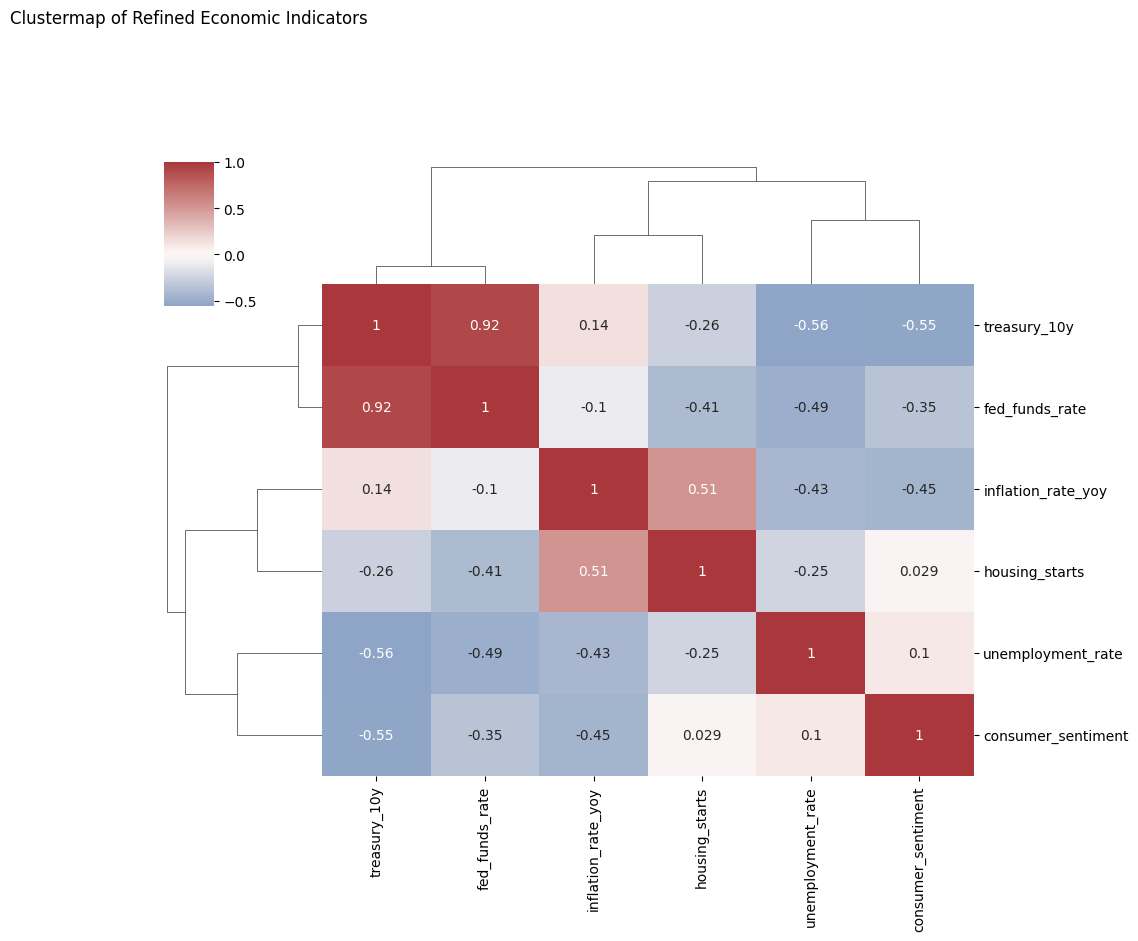

In [63]:
# Clustermap
sns.clustermap(df_for_visualization.corr(), annot=True, cmap='vlag', center=0, figsize=(10, 8))
plt.title("Clustermap of Refined Economic Indicators", pad=100)
plt.show()

The clustermap reorders the features by their mathematical similarity. The correlations as presented largely align with expectations. One notable exception is how the inflation rate and the Federal Funds Rate exhibit very weak negative correlation, while it can be expected that they would be strongly positively correlated. This is likely due to the lag effect of monetary policy. In any case, this demonstrates that the previously-performed EDA analysis has significantly reduced redundancy and will facilitate stable coefficients when learned through logistic regression.

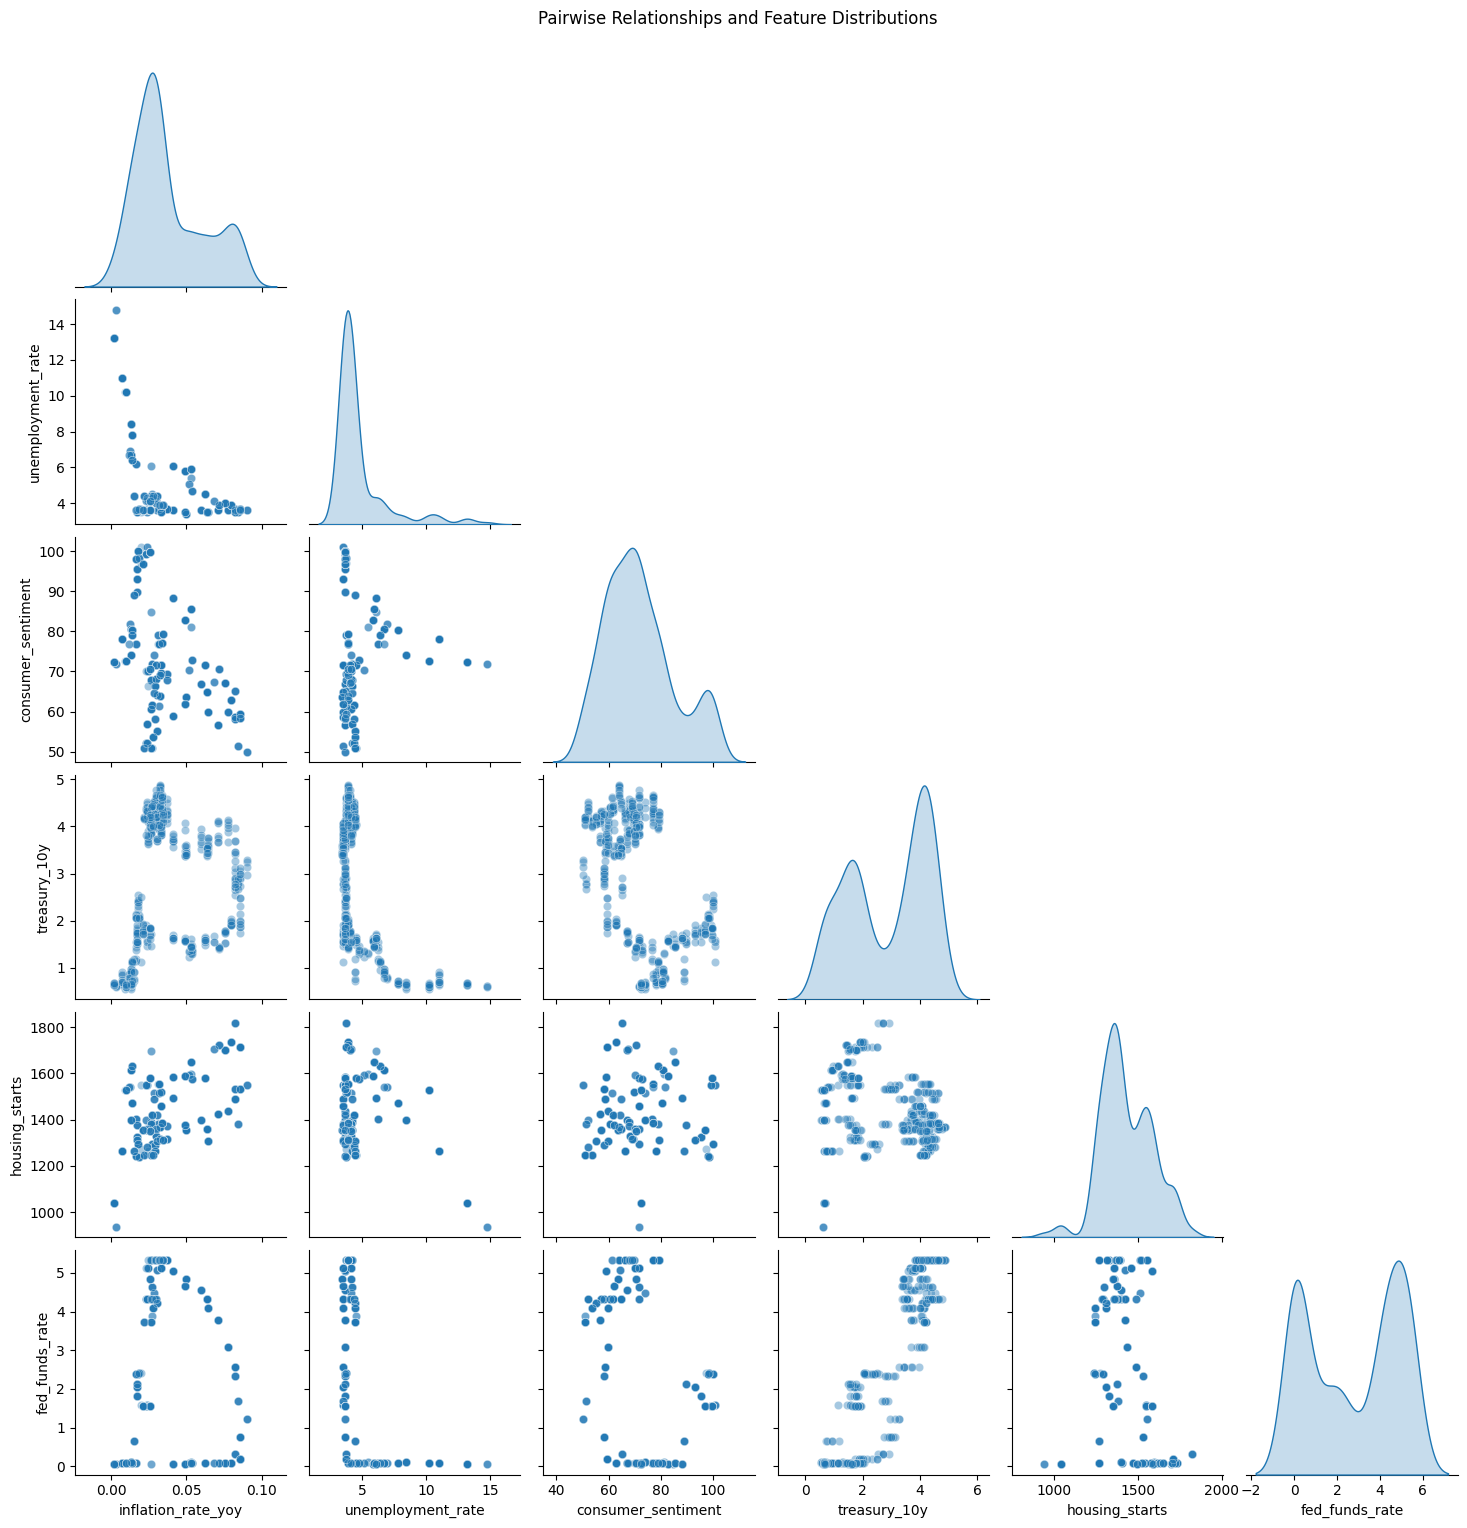

In [64]:
# Pair Plot with KDE
# Sample 500 rows
sns.pairplot(df_for_visualization.sample(500, random_state=42), diag_kind='kde', corner=True, plot_kws={'alpha':0.4})
plt.suptitle("Pairwise Relationships and Feature Distributions", y=1.02)
plt.show()

The feature distributions are certainly consistent with that which would be expected. The inflation rate has a clear center around 2-3%, while the Federal Funds Rate and the 10-year Treasury yield are multi-modal, which is also expected.

As for the scatterplots, the lack of stand-out trends (with few exceptions) heightens confidence that multicolinearity has been greatly diminished.

# Task 3: Logistic Regression Implementation

**Part 1**

In [65]:
import numpy as np

class LogisticRegression:
  def __init__(self, learning_rate=0.01, num_iterations=1000):
    self.learning_rate = learning_rate
    self.num_iterations = num_iterations
    self.weights = None
    self.bias = None
    self.loss_history = []

  def sigmoid(self, z):
    return 1 / (1 + np.exp(-z))

  def compute_loss(self, y_true, y_pred):
    n = len(y_true)
    # Buffer to prevent log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    cost = -(1/n) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    return cost

  def fit_with_batch_gradient_descent(self, X, y):
    n_samples, n_features = X.shape
    self.weights = np.zeros(n_features)
    self.bias = 0

    # BGD loop
    for i in range(self.num_iterations):
      # Linear combo z = w^T X + b
      linear_model = np.dot(X, self.weights) + self.bias
      # Apply sigmoid function
      y_predicted = self.sigmoid(linear_model)

      # Gradients
      dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
      db = (1 / n_samples) * np.sum(y_predicted - y)

      # Update parameters
      self.weights -= self.learning_rate * dw
      self.bias -= self.learning_rate * db

      self.loss_history.append(self.compute_loss(y, y_predicted))

      # Track convergence
      if i % 100 == 0:
        print(f"Iteration: {i}, Loss: {self.loss_history[-1]}")
    # Append final loss
    print(f"Final Loss: {self.loss_history[-1]}")

  def predict(self, X):
    linear_model = np.dot(X, self.weights) + self.bias
    y_predicted = self.sigmoid(linear_model)

    return (y_predicted > 0.5).astype(int)

This implementation of logistic regression with batch gradient descent, as well as a vectorized loss function, uses NumPy to handle parameter updates efficiently through matrix operations. By using the dot product ($X \cdot w + b$) instead of manual loops, the model processes the entire dataset simultaneously for faster computation. I included an epsilon-clipping strategy to prevent numerical errors like $\log(0)$ and initialized the weights to zero to ensure a stable path toward the global minimum.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Day-over-day changes in the FFR
diffs = df_for_visualization['fed_funds_rate'].diff()

# Apply binary logic (1 if increase, 0 if stay/decrease)
# `shift(-1)` used to align the features of one day with rate change of next day
y_binary = np.where(diffs.shift(-1) > 0, 1, 0)

# Assuming y_binary is the array we just created
unique, counts = np.unique(y_binary, return_counts=True)
distribution = dict(zip(unique, counts))

# Output class distribution for greater context
print("Class Distribution:")
print(f"Total Days: {len(y_binary)}")
print(f"No Hike (0): {distribution.get(0, 0)} days ({distribution.get(0, 0)/len(y_binary)*100:.2f}%)")
print(f"Rate Hike (1): {distribution.get(1, 0)} days ({distribution.get(1, 0)/len(y_binary)*100:.2f}%)\n\n")

# Drop the last row since there is no data for the day after the dataset ends
X = df_for_visualization[final_features].values[:-1]
y = y_binary[:-1]
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model with BGD
model = LogisticRegression(learning_rate=0.1, num_iterations=2000)
model.fit_with_batch_gradient_descent(X_train_scaled, y_train)

# Prediction accuracy
predictions = model.predict(X_test_scaled)
accuracy = np.mean(predictions == y_test)
print(f"Model Accuracy on Test Set: {accuracy * 100:.2f}%")

Class Distribution:
Total Days: 2480
No Hike (0): 2455 days (98.99%)
Rate Hike (1): 25 days (1.01%)


Iteration: 0, Loss: 0.6931471805599454
Iteration: 100, Loss: 0.13226812444799702
Iteration: 200, Loss: 0.08508723614136592
Iteration: 300, Loss: 0.07025107698571309
Iteration: 400, Loss: 0.06341897908522307
Iteration: 500, Loss: 0.05963533948182793
Iteration: 600, Loss: 0.057295028539469696
Iteration: 700, Loss: 0.05573567717121059
Iteration: 800, Loss: 0.054639201561687785
Iteration: 900, Loss: 0.053835968664036817
Iteration: 1000, Loss: 0.0532282471721793
Iteration: 1100, Loss: 0.05275627411391694
Iteration: 1200, Loss: 0.0523817255410988
Iteration: 1300, Loss: 0.0520790505615452
Iteration: 1400, Loss: 0.051830651202248015
Iteration: 1500, Loss: 0.051624067561343336
Iteration: 1600, Loss: 0.05145026534601638
Iteration: 1700, Loss: 0.05130255702488054
Iteration: 1800, Loss: 0.05117590129240991
Iteration: 1900, Loss: 0.05106643598981732
Final Loss: 0.05097205005724355
Model Accuracy on

Given the significant class imbalance, where there are only 25 instances in which the Federal Funds Rate is greater than the FFR of the previous day, the model accurary of 98.79% is actually slightly worse than a model that would simply guess no FFR hike for each day.

**Part 2**

In [67]:
class LogisticRegressionEnhanced(LogisticRegression):
  def fit_with_stochastic_gradient_descent(self, X, y):
    n_samples, n_features = X.shape
    self.weights = np.zeros(n_features)
    self.bias = 0
    self.loss_history = []

    for epoch in range(self.num_iterations):
      # Shuffle for variety
      indices = np.random.permutation(n_samples)
      X_sh = X[indices]
      y_sh = y[indices]

      for i in range(n_samples):
        xi, yi = X_sh[i:i+1], y_sh[i:i+1]
        y_pred = self.sigmoid(np.dot(xi, self.weights) + self.bias)
        dw = np.dot(xi.T, (y_pred - yi))
        db = np.sum(y_pred - yi)

        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db
      epoch_pred = self.sigmoid(np.dot(X, self.weights) + self.bias)

      self.loss_history.append(self.compute_loss(y, epoch_pred))

      if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {self.loss_history[-1]}")
    print(f"Final Loss: {self.loss_history[-1]}")

  def fit_with_mini_batch_gradient_descent(self, X, y, batch_size=32):
    n_samples, n_features = X.shape
    self.weights = np.zeros(n_features)
    self.bias = 0
    self.loss_history = []

    for epoch in range(self.num_iterations):
      indices = np.random.permutation(n_samples)
      X_sh = X[indices]
      y_sh = y[indices]

      for i in range(0, n_samples, batch_size):
        xi, yi = X_sh[i:i+batch_size], y_sh[i:i+batch_size]
        y_pred = self.sigmoid(np.dot(xi, self.weights) + self.bias)
        dw = (1 / len(yi)) * np.dot(xi.T, (y_pred - yi))
        db = (1 / len(yi)) * np.sum(y_pred - yi)

        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db
      epoch_pred = self.sigmoid(np.dot(X, self.weights) + self.bias)

      self.loss_history.append(self.compute_loss(y, epoch_pred))
      if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {self.loss_history[-1]}")
    print(f"Final Loss: {self.loss_history[-1]}")

In [68]:
# Test performance of stochastic gradient descent
# The learning rate is lower compared to learning rate for BGD as to
# account for the lower stability.
model_sgd = LogisticRegressionEnhanced(learning_rate=0.01, num_iterations=50)

model_sgd.fit_with_stochastic_gradient_descent(X_train_scaled, y_train)

# Model accuracy
predictions_sgd = model_sgd.predict(X_test_scaled)
accuracy_sgd = np.mean(predictions == y_test)
print(f"SGD Model Accuracy on Test Set: {accuracy * 100:.2f}%")

print()

# Test performance of mini-batch gradient descent
model_mbgd = LogisticRegressionEnhanced(learning_rate=0.01, num_iterations=100)

model_mbgd.fit_with_mini_batch_gradient_descent(X_train_scaled, y_train)

# Model accuracy
predictions_mbgd = model_mbgd.predict(X_test_scaled)
accuracy_mbgd = np.mean(predictions == y_test)

print(f"MBGD Model Accuracy on Test Set: {accuracy * 100:.2f}%")

Epoch: 0, Loss: 0.08588206637711357
Epoch: 10, Loss: 0.05084023340293101
Epoch: 20, Loss: 0.05025184029653733
Epoch: 30, Loss: 0.05011088549538325
Epoch: 40, Loss: 0.05007892678352579
Final Loss: 0.0500533247563292
SGD Model Accuracy on Test Set: 98.79%

Epoch: 0, Loss: 0.5646414612026283
Epoch: 10, Loss: 0.17581199502372477
Epoch: 20, Loss: 0.11077642956907116
Epoch: 30, Loss: 0.08721709344638474
Epoch: 40, Loss: 0.0756200223394919
Epoch: 50, Loss: 0.06891490643398508
Epoch: 60, Loss: 0.06463546124400099
Epoch: 70, Loss: 0.06171213883209357
Epoch: 80, Loss: 0.059615349376233515
Epoch: 90, Loss: 0.058053622528473216
Final Loss: 0.0569618619849096
MBGD Model Accuracy on Test Set: 98.79%


The three gradient descent variants demonstrate the expected trade-off between stability and convergence speed. The first method, batch gradient descent, provides the most stable path to the global minimum of the log-loss cost function because it calculates the true gradient using the entire training set. This results in a perfectly smooth, monotonic decrease in loss, but it is the slowest variant per iteration, which would make it less ideal for larger-scaled datasets. In contrast, stochastic gradient descent converges much faster initially because it performs a weight update for every single daily observation. As evident in the outputs, this allowed SGD to reach a near-minimum loss (0.050) in just 10 epochs. While it is usually anticipated that SGD convergence would be noisy as it reacts to individual outliers, that was not observed here at the 10-epoch reporting increments. This suggests that the 99% class consensus on the "No Hike" label creates a highly consistent gradient that masks the typical stochastic fluctuations.

In this instance, mini-batch gradient descent serves as the optimal middle ground, balancing the strengths of both methods. By averaging gradients over a small subset of data (batch size of 32), it smooths out the potential for stochastic noise while remaining significantly more computationally efficient than full batch GD. In this macroeconomic context, mini-batch GD demonstrated a steady descent, avoiding aggressive reactions to daily noise while still finding the same global minimum as the other variants. Despite these different paths, the extreme 99% class imbalance in the dataset led all three variants to converge toward a strategy that prioritizes the majority class ("No FFR Hike") to minimize the global cost, resulting in the identical accuracy scores observed in the final testing.

# Task 4: Optimization Techniques and Advanced Comparison

**Part 1**

Inital hyperparameters, such as $\beta_1=0.9, \beta_2=0.999$ for the Adam optimization algorithm, have been selected to align with standards, e.g. [Adam: A Method for Stochastic Optimization](https://arxiv.org/pdf/1412.6980).

In [69]:
class OptimizedLogisticRegression(LogisticRegressionEnhanced):
    def __init__(self, learning_rate=0.01, num_iterations=100):
      super().__init__(learning_rate, num_iterations)
      # To prevent division by 0 in RMSProp and Adam
      self.epsilon = 1e-8

    def fit_momentum(self, X, y, beta=0.9, batch_size=32, print_progress=True):
      n_samples, n_features = X.shape
      self.weights = np.zeros(n_features)
      self.bias = 0
      self.loss_history = []

      # Moving average of the gradients for weights and bias
      v_w, v_b = np.zeros(n_features), 0

      for epoch in range(self.num_iterations):
        indices = np.random.permutation(n_samples)
        X_sh, y_sh = X[indices], y[indices]

        for i in range(0, n_samples, batch_size):
          xi, yi = X_sh[i:i+batch_size], y_sh[i:i+batch_size]
          y_pred = self.sigmoid(np.dot(xi, self.weights) + self.bias)
          dw = (1 / len(yi)) * np.dot(xi.T, (y_pred - yi))
          db = (1 / len(yi)) * np.sum(y_pred - yi)

          # Momentum update
          v_w = beta * v_w + (1 - beta) * dw
          v_b = beta * v_b + (1 - beta) * db
          self.weights -= self.learning_rate * v_w
          self.bias -= self.learning_rate * v_b
        self.loss_history.append(self.compute_loss(y, self.sigmoid(np.dot(X, self.weights) + self.bias)))

        if print_progress and epoch % 10 == 0:
          print(f"Epoch: {epoch}, Loss: {self.loss_history[-1]}")

      if print_progress:
        print(f"Final Loss: {self.loss_history[-1]}")

    def fit_rmsprop(self, X, y, beta=0.9, batch_size=32, print_progress=True):
      n_samples, n_features = X.shape
      self.weights = np.zeros(n_features)
      self.bias = 0
      self.loss_history = []

      # Running average of squared gradients
      s_w, s_b = np.zeros(n_features), 0

      for epoch in range(self.num_iterations):
        indices = np.random.permutation(n_samples)
        X_sh, y_sh = X[indices], y[indices]

        for i in range(0, n_samples, batch_size):
          xi, yi = X_sh[i:i+batch_size], y_sh[i:i+batch_size]
          y_pred = self.sigmoid(np.dot(xi, self.weights) + self.bias)
          dw = (1 / len(yi)) * np.dot(xi.T, (y_pred - yi))
          db = (1 / len(yi)) * np.sum(y_pred - yi)

          # RMSProp update (adptive learning rate)
          s_w = beta * s_w + (1 - beta) * (dw**2)
          s_b = beta * s_b + (1 - beta) * (db**2)
          self.weights -= self.learning_rate * dw / (np.sqrt(s_w) + self.epsilon)
          self.bias -= self.learning_rate * db / (np.sqrt(s_b) + self.epsilon)

        self.loss_history.append(self.compute_loss(y, self.sigmoid(np.dot(X, self.weights) + self.bias)))

        if print_progress and epoch % 10 == 0:
          print(f"Epoch: {epoch}, Loss: {self.loss_history[-1]}")

      if print_progress:
        print(f"Final Loss: {self.loss_history[-1]}")

    def fit_adam(self, X, y, beta1=0.9, beta2=0.999, batch_size=32, print_progress=True):
      n_samples, n_features = X.shape
      self.weights = np.zeros(n_features)
      self.bias = 0
      self.loss_history = []

      # 1st moment
      v_w, v_b = np.zeros(n_features), 0
      # 2nd moment
      s_w, s_b = np.zeros(n_features), 0
      t = 0

      for epoch in range(self.num_iterations):
        indices = np.random.permutation(n_samples)
        X_sh, y_sh = X[indices], y[indices]

        for i in range(0, n_samples, batch_size):
          t += 1
          xi, yi = X_sh[i:i+batch_size], y_sh[i:i+batch_size]
          y_pred = self.sigmoid(np.dot(xi, self.weights) + self.bias)
          dw = (1 / len(yi)) * np.dot(xi.T, (y_pred - yi))
          db = (1 / len(yi)) * np.sum(y_pred - yi)

          v_w = beta1 * v_w + (1 - beta1) * dw
          v_b = beta1 * v_b + (1 - beta1) * db
          s_w = beta2 * s_w + (1 - beta2) * (dw**2)
          s_b = beta2 * s_b + (1 - beta2) * (db**2)

          # Bias correction
          v_w_c = v_w / (1 - beta1**t)
          v_b_c = v_b / (1 - beta1**t)
          s_w_c = s_w / (1 - beta2**t)
          s_b_c = s_b / (1 - beta2**t)

          self.weights -= self.learning_rate * v_w_c / (np.sqrt(s_w_c) + self.epsilon)
          self.bias -= self.learning_rate * v_b_c / (np.sqrt(s_b_c) + self.epsilon)
        self.loss_history.append(self.compute_loss(y, self.sigmoid(np.dot(X, self.weights) + self.bias)))

        if print_progress and epoch % 10 == 0:
          print(f"Epoch: {epoch}, Loss: {self.loss_history[-1]}")

      if print_progress:
        print(f"Final Loss: {self.loss_history[-1]}")

Vanilla SGD:
Epoch: 0, Loss: 0.3871943233531887
Epoch: 10, Loss: 0.08151022291238338
Epoch: 20, Loss: 0.06271947544267688
Epoch: 30, Loss: 0.057058537242637784
Epoch: 40, Loss: 0.054537325839996285
Final Loss: 0.05328452176442828
Vanilla SGD Model Accuracy on Test Set: 98.79%

Momentum:
Epoch: 0, Loss: 0.6805088656479729
Epoch: 10, Loss: 0.5552933235578147
Epoch: 20, Loss: 0.46284427978239134
Epoch: 30, Loss: 0.3935819921832472
Epoch: 40, Loss: 0.3407583239913472
Final Loss: 0.3033999263656182
Momentum Model Accuracy on Test Set: 98.79%

RMSProp:
Epoch: 0, Loss: 0.6589977012512128
Epoch: 10, Loss: 0.413920110588694
Epoch: 20, Loss: 0.252993326310004
Epoch: 30, Loss: 0.15572657934858894
Epoch: 40, Loss: 0.1012576491136328
Final Loss: 0.07524210191701886
RMSProp Model Accuracy on Test Set: 98.79%

Adam:
Epoch: 0, Loss: 0.6632016330798316
Epoch: 10, Loss: 0.43367174981226064
Epoch: 20, Loss: 0.2952788106014707
Epoch: 30, Loss: 0.21078845927906453
Epoch: 40, Loss: 0.15752579454278817
Final

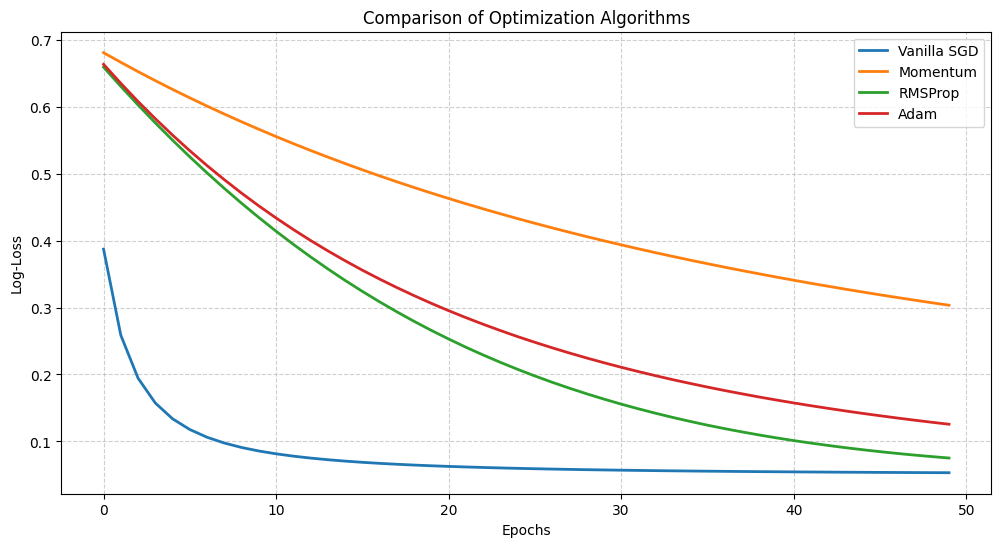

In [70]:
# Same initial hyperparameters
iterations = 50
lr = 0.001
results = {}

# Define the models
model_vanilla = OptimizedLogisticRegression(learning_rate=lr, num_iterations=iterations)
model_momentum = OptimizedLogisticRegression(learning_rate=lr, num_iterations=iterations)
model_rmsprop = OptimizedLogisticRegression(learning_rate=lr, num_iterations=iterations)
model_adam = OptimizedLogisticRegression(learning_rate=lr, num_iterations=iterations)

# Run the training for each
print("Vanilla SGD:")
model_vanilla.fit_with_stochastic_gradient_descent(X_train_scaled, y_train)
results['Vanilla SGD'] = model_vanilla.loss_history
# Accuracy
predictions_vanilla = model_vanilla.predict(X_test_scaled)
accuracy_vanilla = np.mean(predictions_vanilla == y_test)
print(f"Vanilla SGD Model Accuracy on Test Set: {accuracy_vanilla * 100:.2f}%\n")

print("Momentum:")
model_momentum.fit_momentum(X_train_scaled, y_train)
results['Momentum'] = model_momentum.loss_history
# Accuracy
predictions_momentum = model_momentum.predict(X_test_scaled)
accuracy_momentum = np.mean(predictions_momentum == y_test)
print(f"Momentum Model Accuracy on Test Set: {accuracy_momentum * 100:.2f}%\n")

print("RMSProp:")
model_rmsprop.fit_rmsprop(X_train_scaled, y_train)
results['RMSProp'] = model_rmsprop.loss_history
# Accuracy
predictions_rmsprop = model_rmsprop.predict(X_test_scaled)
accuracy_rmsprop = np.mean(predictions_rmsprop == y_test)
print(f"RMSProp Model Accuracy on Test Set: {accuracy_rmsprop * 100:.2f}%\n")

print("Adam:")
model_adam.fit_adam(X_train_scaled, y_train)
results['Adam'] = model_adam.loss_history
# Accuracy
predictions_adam = model_adam.predict(X_test_scaled)
accuracy_adam = np.mean(predictions_adam == y_test)
print(f"Adam Model Accuracy on Test Set: {accuracy_adam * 100:.2f}%\n")

# Plot the comparison
plt.figure(figsize=(12, 6))
for name, history in results.items():
    plt.plot(history, label=name, linewidth=2)

plt.title("Comparison of Optimization Algorithms")
plt.xlabel("Epochs")
plt.ylabel("Log-Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Based on the results, the vanilla stochastic gradient descent implementation significantly outperforms the advanced optimizers in terms of raw convergence speed on the training set. Vanilla SGD achieved a near-minimal loss of 0.081 by epoch 10 and concluded with a final loss of 0.053, whereas RMSProp (0.075), Adam (0.125), and Momentum (0.303) trailed behind considerably. This behavior is expected when using a low, fixed learning rate of $0.001$ (source: https://towardsdatascience.com/effect-of-gradient-descent-optimizers-on-neural-net-training-d44678d27060/); Vanilla SGD utilizes the full step size immediately, while the adaptive optimizers incorporate scaling factors (e.g. $s_w$ and $s_b$) and bias correction that can effectively dampen initial steps on a relatively smooth cost surface. Despite the different loss trajectories, all four algorithms reached an identical 98.79% test accuracy.

**Part 2**

I will implement the three evaluation metrics:


*   Precision, which measures the accuracy of positive predictions; the ratio of correctly identified "FFR Hikes" to the total number of "FFR Hikes" predicted.
*   Recall, which measures the ability to find all positive instances; the ratio of correctly identified "FFR Hikes" to the total number of actual "FFR Hikes" that occurred.
*   F1-score, the harmonic mean of precision and recall, which provides a single balanced metric that is essential for evaluating performance on imbalanced datasets such as this one; requires the model to be both accurate when it predicts a "FFR Hike" and effective at finding most "FFR Hikes."

In [71]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

models = {
    'Vanilla SGD': model_vanilla,
    'Momentum': model_momentum,
    'RMSProp': model_rmsprop,
    'Adam': model_adam
}
results = []

for name, model in models.items():
  y_pred = model.predict(X_test_scaled)

  # Metrics for the "Hike" class
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)

  results.append({
      'Model': name,
      'Precision': precision,
      'Recall': recall,
      'F1 Score': f1,
      'Accuracy': accuracy
  })
print(pd.DataFrame(results))

         Model  Precision  Recall  F1 Score  Accuracy
0  Vanilla SGD        0.0     0.0       0.0  0.987903
1     Momentum        0.0     0.0       0.0  0.987903
2      RMSProp        0.0     0.0       0.0  0.987903
3         Adam        0.0     0.0       0.0  0.987903


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

The evaluation of stochastic gradient descent and the three optimization algorithms further solidifies a significant issue common in imbalanced macroeconomic datasets, clearly including this one. While all models achieved a seemingly high accuracy of approximately 98.79%, the precision, recall, and F1-score for the "FFR Hike" class were all 0.0. This indicates that the models have converged to a majority-class strategy, predicting "No FFR Hike" for nearly every instance in the test set to minimize the log-loss. Since there is slightly worse accuracy than purely guessing "No FFR Hike" for each test point, there are in fact a few false positives predicted.

In this context, accuracy is a misleading metric, as it fails to reflect the model's total inability to identify the rare 1% of target events. The `UndefinedMetricWarning` received during calculation confirms that the decision threshold ($0.5$) was never accurately crossed for the minority class, resulting in zero true positives. For this prediction tool to be practically useful, the recall must be non-zero, as missing 100% of interest rate increases renders the model economically ineffective regardless of its overall accuracy.

**Part 3**

In [72]:
# Hyperparameter grid
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [32, 64]
best_results = {}
models = [
    ("Adam", "fit_adam"),
    ("RMSProp", "fit_rmsprop"),
    ("Momentum", "fit_momentum")
]

for name, method in models:
  best_f1 = -1

  for lr in learning_rates:
    for bs in batch_sizes:
      # Model with current LR
      model = OptimizedLogisticRegression(learning_rate=lr, num_iterations=100)

      # Specific optimization function
      getattr(model, method)(X_train_scaled, y_train, batch_size=bs, print_progress=False)

      # Evaluate
      y_pred = model.predict(X_test_scaled)
      f1 = f1_score(y_test, y_pred, zero_division=0)

      if f1 > best_f1:
        best_f1 = f1
        best_results[name] = {"LR": lr, "Batch": bs, "F1": f1}
print("Grid Search Results:")

for algo, params in best_results.items():
  print(f"{algo}: Best LR={params['LR']}, Batch={params['Batch']}, F1={params['F1']}")

Grid Search Results:
Adam: Best LR=0.0001, Batch=32, F1=0.0
RMSProp: Best LR=0.0001, Batch=32, F1=0.0
Momentum: Best LR=0.0001, Batch=32, F1=0.0


The hyperparameter tuning process, for which I implemented a manual grid search across various learning rates and batch sizes, reinforced the understanding that the model's performance is heavily constrained by the underlying data distribution rather than optimization settings. Despite testing learning rates ranging from $0.0001$ to $0.1$ and two batch sizes, all three advanced optimizers, Adam, RMSProp, and Momentum, consistently returned an F1-score of 0.0. This indicates that the "all-zero" local minimum is exceptionally stable; the gradients produced by the rare 1% "FFR Hike" samples are statistically dwarfed by the approx. 99% majority class, preventing even adaptive algorithms from identifying a predictive signal. The selection of a very low learning rate ($0.0001$) as the "best" result suggests that higher rates likely caused the loss to fluctuate or diverge without ever successfully crossing the $0.5$ decision threshold for a minority class prediction. Ultimately, this demonstrates that while optimization algorithms are known to be superior for navigating complex costs, they cannot inherently overcome extreme class imbalance without supplementary techniques such as class weighting or oversampling.

**Part 4**

The implementation and comparison of various optimization algorithms for Federal Funds Rate forecasting accentuate the critical trade-offs in computational efficiency, interpretability, and practical suitability. From a computational standpoint, vanilla SGD is the least intensive, requiring zero memory for historical gradients, whereas Adam and RMSProp require additional memory to store first and second moments for every parameter, increasing the overall memory usage. Though not demonstrated here, adaptive methods like Adam often prove more efficient in the long run by requiring fewer epochs to navigate complex cost surfaces. With respect to interpretability, simple methods like SGD and Momentum offer a more transparent relationship between input features and weight updates, while the per-parameter scaling used in Adam and RMSProp can obscure the direct influence of specific economic indicators on the final decision.

Ultimately, this assignment demonstrates that while advanced optimizers are superior for numerical stability and convergence speed, they cannot inherently solve the extreme class imbalance present in raw macroeconomic data. Since the log-loss minimum resides at a majority-class strategy, all four algorithms gravitated toward predicting "No FFR Hike" for each day in the test set, resulting in an F1-score of 0.0. A significant structural limitation was the inclusion of every trading day; since FFR changes only occur during FOMC meetings, the dataset was flooded with irrelevant "noise" days where a hike was effectively impossible.

I am able to conclude that for future large-scale Federal Reserve forecasting, these optimization techniques must be integrated with domain-specific preprocessing; specifically, filtering the dataset to only include FOMC meetings. Without this adjustment, even the most sophisticated optimizer remains a "blind" classifier that is statistically accurate but economically ineffective for identifying monetary policy shifts.